This notebook explores the generalisation of `WalkSATlm` to solve `NAE-SAT`

In [17]:
import os
import sys
import warnings
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
warnings.filterwarnings('ignore')
parent_dir = os.path.dirname(os.getcwd())

In [18]:
import h5py
import torch
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Evaluation of hyperparameter grid search:

In [20]:
# Extract
def tiebreak(filename):
	return filename.split("_")[1]

def k_val(filename):
	return int(filename.split("_")[2])

def hyperparameters(filename, tb):
	p = float(filename.split("_")[3].replace(".hdf5", ""))
	w1 = None
	w2 = None
	if tb == 'm2' or tb == 'm2b2' or tb =='lm':
		w1 = round(float(filename.split("_")[4]), 3)
		w2 = round(float(filename.split("_")[5].replace(".hdf5", "")), 3)
	return p, w1, w2

def get_median_mean(filepath):
	with h5py.File(filepath, "r") as f:
		tensor = f["times"][()]
		return np.median(tensor), np.mean(tensor)

# Create an empty Pandas dataframe with the desired columns
columns = ["k", "tiebreak", "p", "w1", "w2", "median", "mean"]
df = pd.DataFrame(columns=columns)

# Loop through all the HDF5 files in the directory and add their data to the dataframe
dir = f"{parent_dir}/experiments/knaesat_benchmark/grid_search"
for filepath in glob.glob(f'{dir}/rt_*.hdf5'):
	filename = filepath.split("/")[-1]
	tb = tiebreak(filename)
	k = k_val(filename)
	p, w1, w2 = hyperparameters(filename, tb)
	if p > 0:
		try:
			median, mean = get_median_mean(filepath)
			df = df.append({"k": k, "tiebreak": tb, "p": p, "w1": w1, "w2": w2, "median": median, "mean": mean}, ignore_index=True)
		except:
			pass

In [21]:
# Find combinations
min_median = df.groupby(['tiebreak', 'k'])['median'].transform('min')
lowest_median_combinations = df[df['median'] == min_median]
lowest_median_combinations = lowest_median_combinations[['tiebreak', 'k', 'p', 'w1', 'w2', 'median']]
lowest_median_combinations = lowest_median_combinations.sort_values(['tiebreak', 'k'])

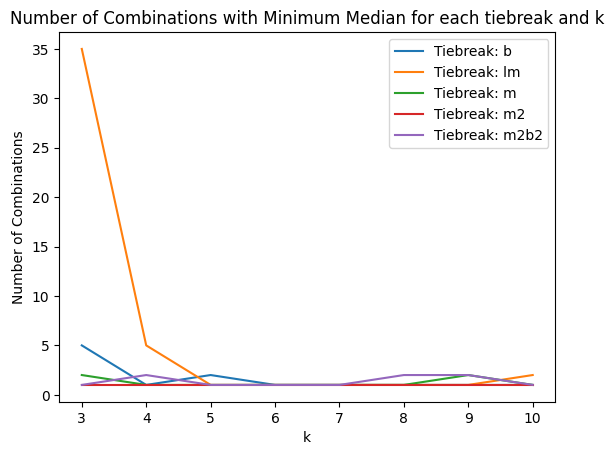

In [22]:
# Plot number of optimal combinations
import matplotlib.pyplot as plt

# Count the number of combinations with the minimum median for each tiebreak and k
num_combinations = lowest_median_combinations.groupby(['tiebreak', 'k']).size()

# Iterate over each tiebreak type
for tiebreak in num_combinations.index.get_level_values('tiebreak').unique():
    tiebreak_combinations = num_combinations.loc[tiebreak]
    # Plot the graph for the tiebreak type
    plt.plot(tiebreak_combinations.index, tiebreak_combinations.values, label=f'Tiebreak: {tiebreak}')

# Set the plot labels and title
plt.xlabel('k')
plt.ylabel('Number of Combinations')
plt.title('Number of Combinations with Minimum Median for each tiebreak and k')

plt.legend()
plt.show()


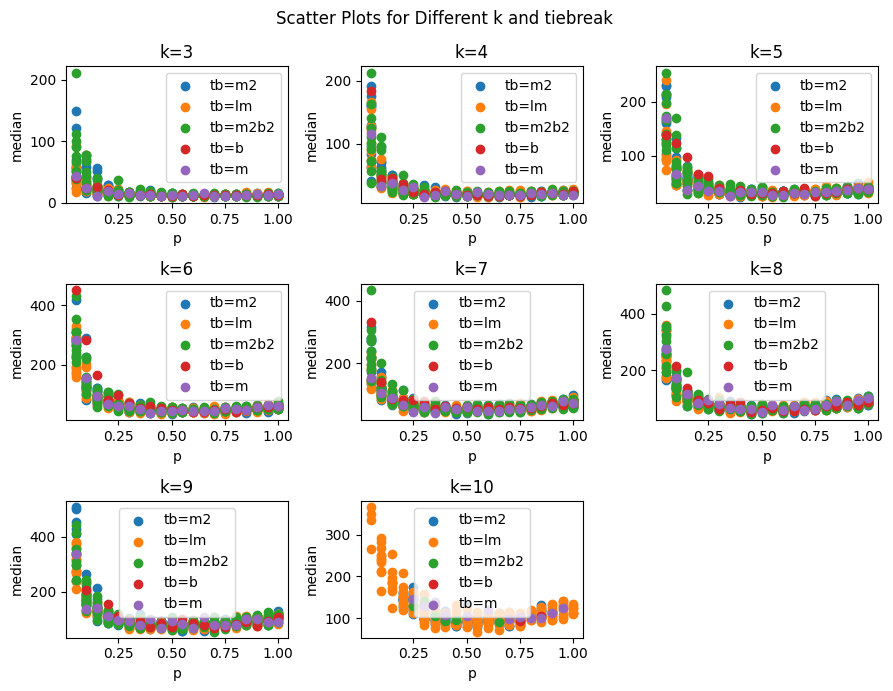

In [23]:
# Dependence on noise
import matplotlib.pyplot as plt
import numpy as np

# Get unique tiebreak values
tiebreak_values = df['tiebreak'].unique()

# Group the data by k
grouped = df.groupby('k')

num_plots = len(grouped)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 7))
fig.suptitle('Scatter Plots for Different k and tiebreak')

# Flatten the axes array to simplify indexing
axes = axes.flatten()

for i, (k, group_k) in enumerate(grouped):
    ax = axes[i]  # Select the current subplot
    ax.set_title(f"k={k}")
    
    for j, tb in enumerate(tiebreak_values):
        group_tb = group_k[group_k['tiebreak'] == tb]
        
        if len(group_tb) > 0:
            p_values = group_tb['p']
            mean_values = group_tb['mean']
            ax.scatter(p_values, mean_values, label=f"tb={tb}")
    
    ax.set_xlabel('p')
    ax.set_ylabel('median')
    ax.legend()

# Hide unused subplots, if any
for i in range(len(grouped), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [56]:
# Parameters
num_proc = 100
batch_size = 10
ks = [i for i in range(3, 10)]
ns = [i for i in range(12, 20)]
tbs = ['lm', 'm2b2']

In [57]:
# Extract
dir = f'{parent_dir}/experiments/knaesat_benchmark/reproduce/'
rts = {k : {n : {tb : torch.zeros(size=(num_proc * batch_size, )) for tb in tbs} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for tb in tbs:
			prev = None
			for proc in range(num_proc):
				filename = f'{dir}/rt_{n}_{k}_{tb}_{proc * batch_size}.hdf5' 
				try:
					with h5py.File(filename, 'r') as file:
						fresh = torch.from_numpy(file.get('times')[:])
						index = proc * batch_size
						rts[k][n][tb][index : index + batch_size] = fresh
						prev = fresh
				except:
					if prev is not None:
						rts[k][n][tb][index : index + batch_size] = prev
					

ws_mrts = {k : {n : {tb : torch.median(torch.masked_select(rts[k][n][tb], rts[k][n][tb] >0)) for tb in tbs} for n in ns} for k in ks}

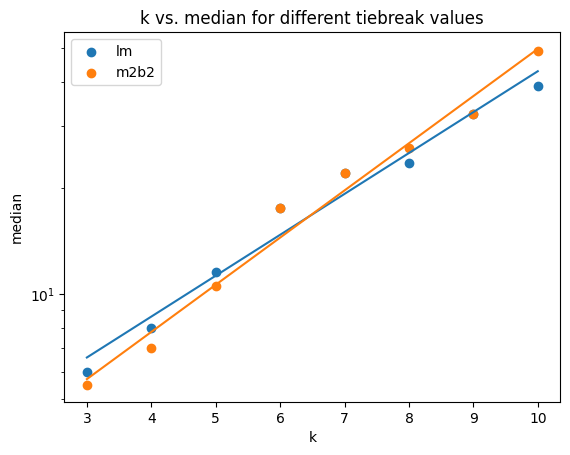

In [78]:
import matplotlib.pyplot as plt

# Sort the DataFrame by 'tiebreak' and 'k'
lowest_median_combinations = lowest_median_combinations.sort_values(['tiebreak', 'k'])

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate over unique 'tiebreak' values
for tiebreak_value in lowest_median_combinations['tiebreak'].unique():
    ks = list(data['k'].unique())
    if (tiebreak_value == 'lm') or (tiebreak_value == 'm2b2'):
        # Filter the DataFrame for the current 'tiebreak' value
        data = lowest_median_combinations[lowest_median_combinations['tiebreak'] == tiebreak_value]
        medians = list(data['median'].unique())
        ax.scatter(ks, medians, label=tiebreak_value)

        coefficients = np.polyfit(ks, np.log2(medians), 1)
        polynomial = np.poly1d(coefficients)
        ax.plot(ks, 2**polynomial(ks))

# Set labels and title
ax.set_xlabel('k')
ax.set_ylabel('median')
ax.set_yscale('log')
ax.set_title('k vs. median for different tiebreak values')

# Add a legend
ax.legend()

# Show the plot
plt.show()


Decision: Randomly sample parameters from combinations that result in minimum median running time.